<a href="https://colab.research.google.com/github/saimasharleen/Active-Learning-Strategies-Across-Diverse-Machine-Learning-Models/blob/main/MNIST_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-oy5bp0zg
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-oy5bp0zg
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 3.2 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=30113042934ba9ed8a155afc1f07af9e10b30a99823ef4821beaadedfb89b514
  Stored in directory: /tmp/pip-ephem-wheel-cache-zys6pzud/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [2]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


In [3]:
# Load MNIST data
mnist_data = MNIST('.', download=True, transform=ToTensor())
dataloader = DataLoader(mnist_data, shuffle=True, batch_size=60000)
x, y = next(iter(dataloader))

100%|██████████| 9912422/9912422 [00:00<00:00, 255551731.79it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 11591932.42it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77321773.61it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 13774785.80it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# Preprocessing
x = x.detach().cpu().numpy().reshape(x.size(0), -1)  # Flatten the images
y = y.detach().cpu().numpy()

In [5]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=0, stratify=y)


In [6]:
# Define confusion matrix print function
def CF_Print(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    CF = confusion_matrix(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    print('Confusion Matrix:')
    print(CF)
    print('Accuracy: ', accuracy)
    print('Macro F1-score: ', macro_f1)
    print('Micro F1-score: ', micro_f1)
    print('Weighted F1-score: ', weighted_f1)
    print("---------------------------------")

In [7]:
# Active Learning with Random Forest
def AL_Retrain(n_initial, n_queries, instances):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    # Initialize the learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=100),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    print("Number of initial data: ", n_initial)
    y_pred = learner.predict(x_test)
    CF_Print(y_test, y_pred)

    # Active Learning Loop
    for idx in range(n_queries):
        print('--- Query no: ', idx+1, ' ----')
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])
        print('Instance', y_pool[query_idx])
        y_pred = learner.predict(x_test)
        CF_Print(y_test, y_pred)

        # Update the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

In [8]:
AL_Retrain(30, 10, 20)

Number of initial data:  30
Confusion Matrix:
[[ 460    3  157   10    7   32  279   20   11    8]
 [   2 1060    2   41    2    2    2    9    1    3]
 [  27  211  497   46   15    3   49   77   11   57]
 [ 131  117  118  544    2   35   17   36   12   10]
 [  31   35   13   20  459    1   66   27   68  254]
 [ 235   65   31  217    5  136   68   34   71   41]
 [ 159   50  130   97   12    0  526    6    4    2]
 [  17   47    3    7   19    4    6  656    8  277]
 [ 116  231   52  182   12  104   44   42  154   38]
 [  13   81   10   23  151   16    5  120   74  499]]
Accuracy:  0.4991
Macro F1-score:  0.47117647301889154
Micro F1-score:  0.4991
Weighted F1-score:  0.4776308600937138
---------------------------------
--- Query no:  1  ----
Instance [4 0 8 4 9 3 9 9 9 8 8 3 3 8 9 3 9 8 2 8]
Confusion Matrix:
[[ 683    2   57  136    9    0   43    9   35   13]
 [   0 1001    1   36    4    0    0    1   81    0]
 [  22   76  364  225   18    0    7   17  241   23]
 [  27   25   21  85

In [9]:
AL_Retrain(30, 10, 30)

Number of initial data:  30
Confusion Matrix:
[[ 453    2  166    6   13   61  123  114   25   24]
 [   1 1097    2    6    6    0    3    4    2    3]
 [  19  218  498   55   48    4   44   62    3   42]
 [ 158  114  149  394    5   67   16   88    9   22]
 [  17   50    9    8  529    4   28   17   89  223]
 [ 180   83   60   88   31  205   40   83   91   42]
 [ 225   59  147   25   80    4  418    8    8   12]
 [   5   58    2    6   89    3    0  719   11  151]
 [ 107  240   77   88   17  121   25   96  137   67]
 [  12   64    1    8  207   22    6  144   61  467]]
Accuracy:  0.4917
Macro F1-score:  0.46333630944723814
Micro F1-score:  0.4917
Weighted F1-score:  0.4691142149711354
---------------------------------
--- Query no:  1  ----
Instance [6 8 2 6 6 6 6 8 8 6 7 8 8 6 0 6 8 0 5 6 0 8 8 8 5 6 0 5 8 8]
Confusion Matrix:
[[914   1   8   0   3   0  29  17  15   0]
 [  1 871   2   0   2   9 149  10  80   0]
 [ 62  63 351   4   5  13 271  18 196  10]
 [105   8  31 127   0 148  41 

In [10]:
AL_Retrain(50, 10, 20)

Number of initial data:  50
Confusion Matrix:
[[ 768    3   52    7    2    4  128   16    0    7]
 [   0 1068    1    0    0    2    3   42    1    7]
 [  18  198  593   71    6    0   36   30   16   25]
 [  25   85   74  665    2   34   29   54   22   32]
 [   4   48   25    1  560    1   33   23    4  275]
 [  83  150   25  165   26  228   45   65   18   98]
 [  49   89   55   35   36    3  696    6    3   14]
 [   4   79   36    1   44    1   24  634    1  220]
 [  33  251   53  165    5   36   12   28  301   91]
 [   7   35   17   11  146    8   37  129    3  599]]
Accuracy:  0.6112
Macro F1-score:  0.5945527345880105
Micro F1-score:  0.6112
Weighted F1-score:  0.5979043619098205
---------------------------------
--- Query no:  1  ----
Instance [7 5 3 8 3 5 0 3 5 5 5 5 0 8 8 5 3 5 8 3]
Confusion Matrix:
[[ 916    0   10    8    3   12   10    1   27    0]
 [   1 1020    1    7    0    8    0   75    4    8]
 [  55  200  475  102    3    8    4   38   89   19]
 [  30   16   12  826

In [11]:
AL_Retrain(50, 10, 30)

Number of initial data:  50
Confusion Matrix:
[[ 816    2   25    2    2    6  102   21    6    5]
 [   1 1000    3    9    2    2    0   97    2    8]
 [  27  244  555   22   19    1   31   25   29   40]
 [  47   69   65  606    1   56   25   41   65   47]
 [   6   35   27    2  547    0   47   12   14  284]
 [  78   87   13  115   12  328   61   35   73  101]
 [  59   48   32   36   18    3  763    3    9   15]
 [  11   45   47    2   56    2   11  508    7  355]
 [  25  194   40  100   12   54   21   19  415   95]
 [   7   11   45    7  253   15    9   62   30  553]]
Accuracy:  0.6091
Macro F1-score:  0.6018432773552006
Micro F1-score:  0.6091
Weighted F1-score:  0.6040340669643627
---------------------------------
--- Query no:  1  ----
Instance [8 8 6 6 5 5 5 2 5 5 8 6 5 5 6 5 6 3 6 5 5 5 5 6 5 2 5 6 6 8]
Confusion Matrix:
[[401   0  60  15   0 415  89   1   6   0]
 [  0 996   0   0   1  60  25  36   3   3]
 [  5  92 555  14   0  64 166   5  83   9]
 [  2   8  45 404   0 435  37  

In [12]:
 AL_Retrain(100, 10, 20)

Number of initial data:  100
Confusion Matrix:
[[ 871    2   22    8    6    1   63    5    5    4]
 [   0 1078    5    6    0    3    2   20    2    8]
 [  23  107  693   68    7    3   14   26   23   29]
 [  12   21   65  739    3   56   14   21   58   33]
 [   2   20   26   13  699    5   20    7   17  165]
 [  72   74    6   83   23  478   24   14   55   74]
 [   7   30   44   13   40   40  804    0    2    6]
 [  14   34   17    4   30    2    1  760    0  182]
 [  19  112   49  110   13   43   13   29  494   93]
 [   7   12   11   13  189   15    5   67   16  657]]
Accuracy:  0.7273
Macro F1-score:  0.7214906820102515
Micro F1-score:  0.7273
Weighted F1-score:  0.7240671588538871
---------------------------------
--- Query no:  1  ----
Instance [0 8 2 5 5 7 4 3 4 8 8 3 5 2 5 5 8 4 2 8]
Confusion Matrix:
[[ 910    0   12    5    4   21   21    6    7    1]
 [   0 1064    5   15    4    7    1   16   10    2]
 [  30  117  662   66   16   12    9   14   63    4]
 [  26   18   35  74

In [13]:
AL_Retrain(300, 10, 20)

Number of initial data:  300
Confusion Matrix:
[[ 944    1   11    5    1    4   12    0    8    1]
 [   0 1095    6    4    2    6    3    4    2    2]
 [  15   47  774   44   15    2   20   34   33    9]
 [  10   16   30  828    2   42    7   17   38   32]
 [   4    9   15    1  840    1   23    3   13   65]
 [  26   40    6   64   27  617   28    3   30   62]
 [  10    8   32    3   26    5  901    0    1    0]
 [   7   27   16    8   46    2    2  849    2   85]
 [   3   54   22  100   13   54   18    9  661   41]
 [   4   15    9   13   70    7    1   42   11  820]]
Accuracy:  0.8329
Macro F1-score:  0.8293341957922793
Micro F1-score:  0.8329000000000001
Weighted F1-score:  0.8309646308079367
---------------------------------
--- Query no:  1  ----
Instance [3 8 5 6 8 2 5 5 8 3 8 5 3 8 5 5 8 4 5 5]
Confusion Matrix:
[[ 926    0    9    7    0   21   15    0    7    2]
 [   0 1088    9    2    1    6    0    4   10    4]
 [  14   60  767   25    9   13   16   22   56   11]
 [   8  

In [14]:

AL_Retrain(300, 10, 30)

Number of initial data:  300
Confusion Matrix:
[[ 938    0    9    6    2    3   21    0    7    1]
 [   1 1095    6    7    2    3    2    4    2    2]
 [  20   60  781   33    8    5   15   24   30   17]
 [   7   17   40  806    1   58   11   23   24   35]
 [   4    8   20    1  802    2   22    5    9  101]
 [  39   24    6  104   23  605   21    2   22   57]
 [  10   10   32   11   38    3  880    0    2    0]
 [  13   30   18    4   40    5    0  837    2   95]
 [  11   59   30   79   10   49   22    6  668   41]
 [   7   15    7   12   82    7    3   39   11  809]]
Accuracy:  0.8221
Macro F1-score:  0.8187385614143956
Micro F1-score:  0.8221
Weighted F1-score:  0.8205133092408783
---------------------------------
--- Query no:  1  ----
Instance [8 5 8 5 5 5 5 8 5 5 5 3 5 4 8 8 3 3 5 8 6 8 2 5 3 5 3 9 3 5]
Confusion Matrix:
[[ 927    0    6    8    0   26    8    1    8    3]
 [   0 1092    6    7    2    6    1    5    2    3]
 [  20   63  746   53   11    8   11   29   45    7]


In [15]:
# Function to conduct active learning and track performance
def AL_Retrain(n_initial, n_queries, instances):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=100),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    performance_history = [accuracy_score(y_test, learner.predict(x_test))]

    # Active Learning Loop
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])

        # Remove the queried instance from the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Calculate and record performance
        model_accuracy = accuracy_score(y_test, learner.predict(x_test))
        performance_history.append(model_accuracy)

    return performance_history

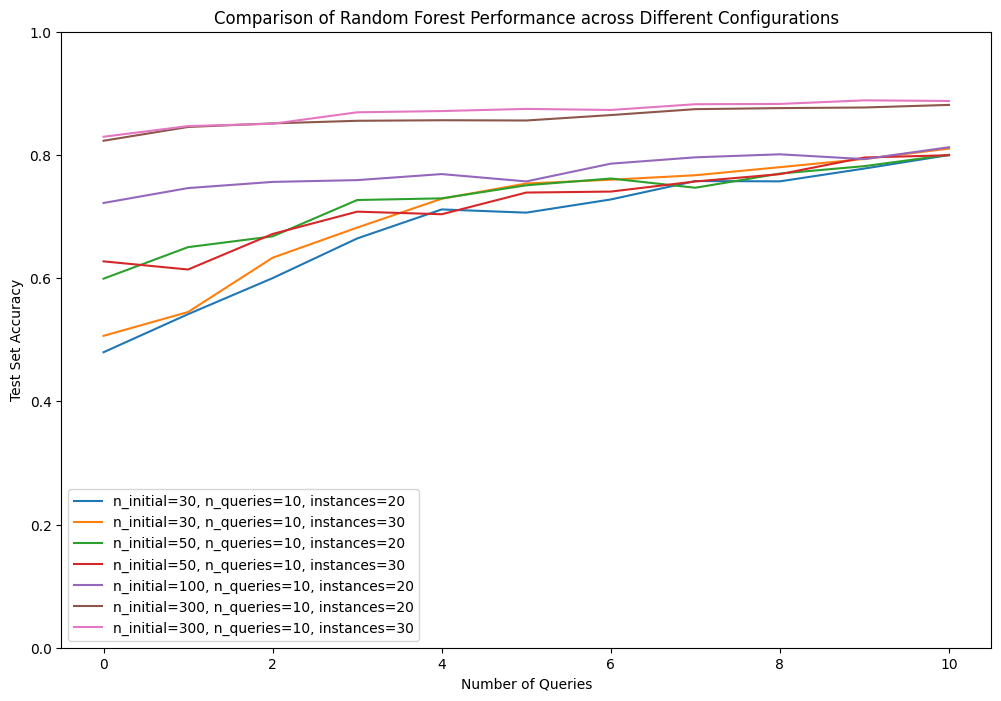

In [17]:
# plot_for_performance_change_queries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

# Define the active learning function with parameters
def AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test):
    x_initial, x_pool, y_initial, y_pool = train_test_split(x_train, y_train, train_size=n_initial, random_state=0, stratify=y_train)

    learner = ActiveLearner(
        estimator=RandomForestClassifier(n_estimators=100),
        query_strategy=uncertainty_sampling,
        X_training=x_initial, y_training=y_initial
    )

    performance_history = [accuracy_score(y_test, learner.predict(x_test))]

    # Active Learning Loop
    for idx in range(n_queries):
        query_idx, query_instance = learner.query(x_pool, n_instances=instances)
        learner.teach(X=x_pool[query_idx], y=y_pool[query_idx])

        # Remove the queried instance from the pool
        x_pool = np.delete(x_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        # Calculate and record performance
        model_accuracy = accuracy_score(y_test, learner.predict(x_test))
        performance_history.append(model_accuracy)

    return performance_history

# Configurations to compare
configurations = [
    (30, 10, 20),
    (30, 10, 30),
    (50, 10, 20),
    (50, 10, 30),
    (100, 10, 20),
    (300, 10, 20),
    (300, 10, 30)
]

# Run each configuration
performance_histories = {}
for config in configurations:
    n_initial, n_queries, instances = config
    performance_histories[config] = AL_Retrain(n_initial, n_queries, instances, x_train, y_train, x_test, y_test)

# Plot the performances
plt.figure(figsize=(12, 8))
for config, history in performance_histories.items():
    plt.plot(history, label=f'n_initial={config[0]}, n_queries={config[1]}, instances={config[2]}')

plt.title("Comparison of Random Forest Performance across Different Configurations")
plt.xlabel("Number of Queries")
plt.ylabel("Test Set Accuracy")
plt.legend()
plt.ylim(0, 1)
plt.show()
